Recreate a model based on the third place solution of the [Tick Tick Bloom: Harmful Algal Bloom Detection Challenge](https://github.com/drivendataorg/tick-tick-bloom/tree/main)

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import yaml

from cyano.config import FeaturesConfig, ModelTrainingConfig
from cyano.experiment import ExperimentConfig
from cyano.settings import REPO_ROOT

/opt/anaconda3/envs/cyanobacteria-prediction/lib/python3.10/site-packages/pydantic/_internal/_fields.py:126: UserWarning: Field "model_training_config" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [3]:
DATA_DIR = REPO_ROOT.parent / "data/experiments"

SPLITS_DIR = DATA_DIR / "splits"
LOCAL_CACHE_DIR = DATA_DIR / "cache"
EXPERIMENT_SAVE_DIR = DATA_DIR / "rerun_third"
EXPERIMENT_SAVE_DIR.mkdir(exist_ok=True, parents=True)

## Settings

Write config to match third place code

In [4]:
use_sentinel_bands = [
    "AOT",
    "B01",
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B09",
    "B11",
    "B12",
    "B8A",
    "SCL",
    "WVP",
]
sat_image_fts = [
    f"{band}_{stat}"
    for band in use_sentinel_bands
    for stat in ["mean", "min", "max", "range"]
]
sat_image_fts += ["NDVI_B04", "NDVI_B05", "NDVI_B06", "NDVI_B07"]
sat_image_fts[:6]

['AOT_mean', 'AOT_min', 'AOT_max', 'AOT_range', 'B01_mean', 'B01_min']

In [5]:
len(sat_image_fts)

64

In [6]:
features_config = FeaturesConfig(
    image_feature_meter_window=200,
    n_sentinel_items=15,
    pc_meters_search_window=5000,
    pc_days_search_window=15,
    use_sentinel_bands=use_sentinel_bands,
    satellite_image_features=sat_image_fts,
    satellite_meta_features=["month", "days_before_sample"],
    metadata_features=["rounded_longitude"],
)

In [7]:
model_config = ModelTrainingConfig(
    num_boost_round=100000,
    params={
        "application": "regression",
        "metric": "rmse",
        "max_depth": -1,
        "num_leaves": 31,
        "learning_rate": 0.1,
    },
)

In [9]:
experiment_config = ExperimentConfig(
    features_config=features_config,
    train_csv=SPLITS_DIR / "competition/train.csv",
    predict_csv=SPLITS_DIR / "competition/test.csv",
    cache_dir=LOCAL_CACHE_DIR,
    save_dir=EXPERIMENT_SAVE_DIR,
)

with (EXPERIMENT_SAVE_DIR / "experiment_config.yaml").open("w") as fp:
    yaml.dump(experiment_config.model_dump(), fp)

## Run experiment

In [ ]:
experiment_config.run_experiment()

2023-08-11 15:56:53.911 | INFO     | cyano.pipeline:_prep_train_data:49 - Loaded 17,060 samples for training
2023-08-11 15:56:53.912 | INFO     | cyano.data.satellite_data:generate_candidate_metadata:194 - Generating metadata for all satellite item candidates


#### Experiment with larger subset of comp data

In [9]:
train = pd.read_csv(SPLITS_DIR / "competition/train.csv")

train_sub_path = "train_sub.csv"
train_sub = train.sample(n=50, random_state=4)
train_sub.to_csv(train_sub_path, index=False)
train_sub.head(2)

,uid,data_provider,region,latitude,longitude,date,density_cells_per_ml,severity,distance_to_water_m
1174,buvf,N.C. Division of Water Resources N.C. Departme...,south,35.790,-79.034845,2020-12-10,87137.0,2,524.0
3732,frko,N.C. Division of Water Resources N.C. Departme...,south,35.976,-78.757882,2016-05-10,279709.0,3,656.0


In [10]:
test = pd.read_csv(SPLITS_DIR / "competition/test.csv")

test_sub_path = "test_sub.csv"
test_sub = test.sample(n=50, random_state=4)
test_sub.to_csv(test_sub_path, index=False)
test_sub.head(2)

,uid,data_provider,region,latitude,longitude,date,density_cells_per_ml,severity,distance_to_water_m
6054,ygor,Indiana State Department of Health,midwest,39.586383,-84.994867,2019-07-22,101041.0,3,0.0
675,csov,California Environmental Data Exchange Network,west,39.624200,-122.197000,2017-10-25,5667500.0,4,1059.0


2023-08-11 11:45:35.248 | INFO     | cyano.pipeline:_prep_train_data:52 - Loaded 50 samples for training
2023-08-11 11:45:35.249 | INFO     | cyano.data.satellite_data:generate_candidate_metadata:192 - Generating metadata for all satellite item candidates
2023-08-11 11:45:41.114 | INFO     | cyano.data.satellite_data:generate_candidate_metadata:202 - Loaded 56,173 rows of Sentinel candidate metadata from s3://drivendata-competition-nasa-cyanobacteria/data/interim/full_pc_search
2023-08-11 11:45:41.969 | INFO     | cyano.data.satellite_data:identify_satellite_data:297 - Selecting which items to use for feature generation
100%|██████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 133.33it/s]
2023-08-11 11:45:42.361 | INFO     | cyano.data.satellite_data:identify_satellite_data:316 - Identified satellite imagery for 34 samples
2023-08-11 11:45:42.632 | INFO     | cyano.pipeline:_prepare_features:62 - 117 rows of satellite metadata save

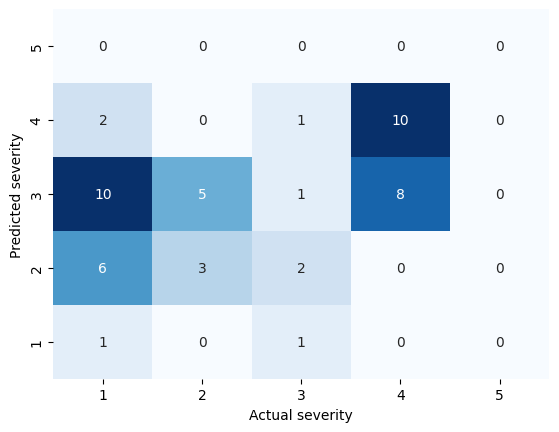

In [178]:
experiment_save_dir = "competition_split_subset"
experiment_config = ExperimentConfig(
    features_config=features_config,
    train_csv=train_sub_path,
    predict_csv=test_sub_path,
    cache_dir=LOCAL_CACHE_DIR,
    save_dir=experiment_save_dir,
    debug=False,
)

experiment_config.run_experiment()

/opt/anaconda3/envs/cyanobacteria-prediction/lib/python3.10/site-packages/pydantic/_internal/_fields.py:126: UserWarning: Field "model_training_config" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
2023-08-11 14:09:42.898 | INFO     | cyano.pipeline:_prep_train_data:49 - Loaded 50 samples for training
2023-08-11 14:09:42.899 | INFO     | cyano.data.satellite_data:generate_candidate_metadata:192 - Generating metadata for all satellite item candidates
2023-08-11 14:09:48.286 | INFO     | cyano.data.satellite_data:generate_candidate_metadata:202 - Loaded 56,173 rows of Sentinel candidate metadata from s3://drivendata-competition-nasa-cyanobacteria/data/interim/full_pc_search
2023-08-11 14:09:49.309 | INFO     | cyano.data.satellite_data:identify_satellite_data:297 - Selecting which items to use for feature generation
100%|█████████████████████████████████████████████████████

CPU times: user 1min 45s, sys: 4.27 s, total: 1min 49s
Wall time: 32.4 s


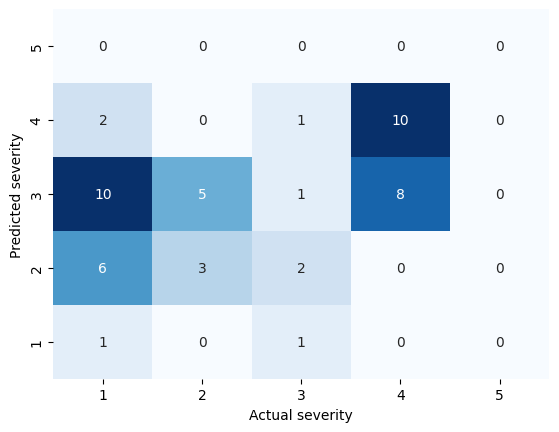

In [23]:
%%time
experiment_save_dir = "competition_split_subset"
experiment_config = ExperimentConfig(
    features_config=features_config,
    model_training_config=model_config,
    train_csv=train_sub_path,
    predict_csv=test_sub_path,
    cache_dir=LOCAL_CACHE_DIR,
    save_dir=experiment_save_dir,
    debug=False,
)

experiment_config.run_experiment()

In [14]:
trained_pipeline = CyanoModelPipeline.from_disk(
    "competition_split_subset/model.zip", cache_dir=LOCAL_CACHE_DIR
)

In [24]:
model = trained_pipeline.model
type(model) == lgb.Booster

True

In [20]:
ft_importance = pd.DataFrame(
    {
        "feature": model.feature_name(),
        "importance_gain": model.feature_importance(importance_type="gain"),
        "importance_split": model.feature_importance(importance_type="split"),
    }
)
ft_importance.head()

,feature,importance_gain,importance_split
0,AOT_mean,1.234578,8133
1,AOT_min,1.414103,983
2,AOT_max,0.000000,0
3,AOT_range,0.181301,790
4,B01_mean,0.203065,2094


In [22]:
ft_importance.sort_values(by="importance_gain", ascending=False).head(10)

,feature,importance_gain,importance_split
66,rounded_longitude,642.707034,6406
39,B09_range,34.853093,3248
9,B02_min,19.558242,3034
45,B12_min,18.501496,5684
15,B03_range,15.679932,1322
65,days_before_sample,15.201443,40259
63,NDVI_B07,14.334613,6564
62,NDVI_B06,12.153718,2849
60,NDVI_B04,12.086767,56722
55,SCL_range,11.282717,739


In [ ]:
# load model from disk


In [ ]:
trained_pipeline = CyanoModelPipeline(features_config=features_config,
                                      model_training_config=model_config,
                                      cache_dir=LOCAL_CACHE_DIR,
                                      model=
                                      

## Training

In [159]:
TEST_ASSETS_DIR = REPO_ROOT.parent / "tests/assets"

In [160]:
pipeline = CyanoModelPipeline(
    features_config=features_config,
    model_training_config=model_config,
    cache_dir=LOCAL_CACHE_DIR,
)
pipeline.run_training(TEST_ASSETS_DIR / "train_data.csv", save_path="/tmp/model.zip")

2023-08-11 10:53:41.975 | INFO     | cyano.pipeline:_prep_train_data:52 - Loaded 5 samples for training
2023-08-11 10:53:41.976 | INFO     | cyano.data.satellite_data:generate_candidate_metadata:192 - Generating metadata for all satellite item candidates
2023-08-11 10:53:41.978 | INFO     | cyano.data.satellite_data:generate_candidate_metadata:211 - Searching ['sentinel-2-l2a'] within 15 days and 5000 meters
100%|█████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.96s/it]
2023-08-11 10:53:56.790 | INFO     | cyano.data.satellite_data:generate_candidate_metadata:241 - Generated metadata for 4 Sentinel item candidates
2023-08-11 10:53:56.792 | INFO     | cyano.data.satellite_data:identify_satellite_data:297 - Selecting which items to use for feature generation
100%|████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 363.92it/s]
2023-08-11 10:53:56.814 | INFO     | cyano.dat

In [140]:
pipeline.train_samples["region"] = ["south", "south", "south", "south", "south"]
pipeline.train_samples

,date,latitude,longitude,severity,region
uid,,,,,
e3ebefd90a00c3cc9f5aeaf32cd4c184,2015-06-29,41.424144,-73.206937,1,south
671520fa92f555ab335e0cfa888c57e7,2013-07-25,36.045000,-79.091942,1,south
9c601f226c2af07d570134127a7fda27,2017-08-21,35.884524,-78.953997,3,south
3a2c48812b551d720f8d56772efa6df1,2019-08-28,41.392490,-75.360700,2,south
2543db364f727f17fe4ce7881aa180da,2013-07-11,38.305600,-122.026000,4,south


In [141]:
pipeline.train_features

,AOT_mean,AOT_min,AOT_max,AOT_range,B01_mean,B01_min,B01_max,B01_range,B02_mean,B02_min,...,WVP_max,WVP_range,NDVI_B04,NDVI_B05,NDVI_B06,NDVI_B07,month,days_before_sample,rounded_longitude,fold
sample_id,,,,,,,,,,,,,,,,,,,,,
9c601f226c2af07d570134127a7fda27,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,8.0,4.0,-8.0,-1
9c601f226c2af07d570134127a7fda27,95.586168,95.0,96.0,1.0,4452.640625,3186.0,7687.0,4501.0,4323.993197,2168.0,...,4300.0,3162.0,0.121759,0.054942,0.017671,-0.007689,8.0,9.0,-8.0,-1
3a2c48812b551d720f8d56772efa6df1,129.913742,129.0,130.0,1.0,12258.953125,11413.0,13228.0,1815.0,11568.770970,10448.0,...,2934.0,0.0,-0.025785,-0.044395,-0.024266,-0.018886,8.0,14.0,-8.0,-1
3a2c48812b551d720f8d56772efa6df1,96.000000,96.0,96.0,0.0,289.156250,245.0,402.0,157.0,271.728138,189.0,...,1659.0,762.0,0.736759,0.519615,0.102936,0.021354,8.0,4.0,-8.0,-1
3a2c48812b551d720f8d56772efa6df1,151.995241,151.0,152.0,1.0,678.109375,241.0,1528.0,1287.0,728.650208,275.0,...,3353.0,1682.0,0.543555,0.382714,0.096019,0.013761,8.0,9.0,-8.0,-1


In [142]:
pipeline.train_labels

uid
e3ebefd90a00c3cc9f5aeaf32cd4c184    1
671520fa92f555ab335e0cfa888c57e7    1
9c601f226c2af07d570134127a7fda27    3
3a2c48812b551d720f8d56772efa6df1    2
2543db364f727f17fe4ce7881aa180da    4
Name: severity, dtype: int64

In [60]:
lgb_data = lgb.Dataset(
    pipeline.train_features,
    label=pipeline.train_labels.loc[pipeline.train_features.index],
)

In [ ]:
model = lgb.train(
    pipeline.model_training_config.params.model_dump(),
    lgb_data,
    num_boost_round=pipeline.model_training_config.num_boost_round,
)

## Parallelize downloads

In [8]:
pipeline = CyanoModelPipeline(
    features_config=features_config,
    model_training_config=model_config,
    cache_dir=LOCAL_CACHE_DIR,
)

In [9]:
pipeline._prep_train_data(TEST_ASSETS_DIR / "train_data.csv")

2023-08-11 15:15:25.281 | INFO     | cyano.pipeline:_prep_train_data:49 - Loaded 5 samples for training


***

In [10]:
sat_meta = identify_satellite_data(pipeline.train_samples, pipeline.features_config)
sat_meta.shape

2023-08-11 15:15:48.319 | INFO     | cyano.data.satellite_data:generate_candidate_metadata:194 - Generating metadata for all satellite item candidates
2023-08-11 15:15:48.320 | INFO     | cyano.data.satellite_data:generate_candidate_metadata:213 - Searching ['sentinel-2-l2a'] within 15 days and 5000 meters
100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]
2023-08-11 15:15:51.886 | INFO     | cyano.data.satellite_data:generate_candidate_metadata:243 - Generated metadata for 4 Sentinel item candidates
2023-08-11 15:15:51.888 | INFO     | cyano.data.satellite_data:identify_satellite_data:299 - Selecting which items to use for feature generation
100%|████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 320.39it/s]
2023-08-11 15:15:51.911 | INFO     | cyano.data.satellite_data:identify_satellite_data:318 - Identified satellite imagery for 2 samples


(4, 25)

In [11]:
sat_meta.head(2)

,item_id,datetime,platform,min_long,max_long,min_lat,max_lat,eo:cloud_cover,AOT_href,B01_href,...,B07_href,B08_href,B09_href,B11_href,B12_href,B8A_href,SCL_href,WVP_href,days_before_sample,sample_id
0,S2B_MSIL2A_20170812T155859_R097_T17SPV_2021013...,2017-08-12,Sentinel-2B,-79.902146,-78.668785,35.133006,36.139741,55.916640,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,9,9c601f226c2af07d570134127a7fda27
1,S2A_MSIL2A_20190814T154911_R054_T18TVL_2020100...,2019-08-14,Sentinel-2A,-76.199460,-74.882965,40.556707,41.551785,82.642989,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,14,3a2c48812b551d720f8d56772efa6df1


In [13]:
from cyano.data.satellite_data import download_satellite_data_new

In [15]:
cache_dir = "image_cache"

In [16]:
download_satellite_data_new(
    sat_meta, pipeline.train_samples, pipeline.features_config, cache_dir
)

2023-08-11 15:16:59.374 | INFO     | cyano.data.satellite_data:download_satellite_data_new:449 - Downloading bands ['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP']


  0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
from cyano.data.satellite_data import get_bounding_box, download_row
import functools

from cloudpathlib import AnyPath
import geopy.distance as distance
from loguru import logger
import numpy as np
import pandas as pd
from pathlib import Path
import planetary_computer as pc
from pystac_client import Client, ItemSearch
import rioxarray
from tqdm import tqdm

In [13]:
NUM_THREADS = 4

In [14]:
cache_dir = "image_cache"
Path(cache_dir).mkdir(exist_ok=True)

In [15]:
imagery_dir = Path(cache_dir) / f"sentinel_{features_config.image_feature_meter_window}"

In [20]:
process_result = process_map(
    functools.partial(
        download_row,
        samples=pipeline.train_samples,
        imagery_dir=imagery_dir,
        config=features_config,
    ),
    sat_meta.iterrows(),
    max_workers=NUM_THREADS,
    chunksize=1,
    total=len(sat_meta),
)

  0%|          | 0/5 [00:00<?, ?it/s]

PicklingError: Can't pickle <function download_row at 0x12e74f490>: it's not the same object as cyano.data.satellite_data.download_row

In [19]:
sum(process_result)

0

In [51]:
for idx, row in tqdm(sat_meta.iterrows(), total=len(sat_meta)):
    download_row(row)

100%|█████████████████████████████████████████████████████████████████████| 5/5 [01:05<00:00, 13.10s/it]


In [41]:
sample_row = pipeline.train_samples.loc[row.sample_id]
sample_row

date         2019-08-28
latitude       41.39249
longitude      -75.3607
severity              2
Name: 3a2c48812b551d720f8d56772efa6df1, dtype: object

In [42]:
(minx, miny, maxx, maxy) = get_bounding_box(
    sample_row.latitude,
    sample_row.longitude,
    features_config.image_feature_meter_window,
)

In [43]:
band = features_config.use_sentinel_bands[0]
band

'AOT'

In [ ]:
unsigned_href = 